## Business Case: Scaler - Clustering

- **Problem Statement**:

     Given information about a specific group of learners, the objective is to organize them into clusters based on factors such as their job profile, company, and other features, aiming for clusters with similar characteristics.

**Column Profiling:** 

- ‘Unnamed 0’- Index of the dataset
- Email_hash- Anonymised Personal Identifiable Information (PII)
- Company_hash- Current employer of the learner
- orgyear- Employment start date
- CTC- Current CTC
- Job_position- Job profile in the company
- CTC_updated_year: Year in which CTC got updated (Yearly increments, Promotions)


**Concept Used:**
- Manual Clustering
- Unsupervised Clustering - K- means++, Hierarchical Clustering

In [219]:
# importing reqd libraries/modules

#For dealing with tables
import pandas as pd

#For dealing with linear algebra
import numpy as np

#For data visualization and plotting graphs
import matplotlib.pyplot as plt
import seaborn as sns

# for missing value treatment
from sklearn.impute import KNNImputer

#regex
import re

# for encoding categorical data
from sklearn.preprocessing import LabelEncoder

# for scaling the data
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# for clustering
from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score

# import hierarchical clustering libraries
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

import warnings
# Ignore all warnings
warnings.filterwarnings("ignore")

In [2]:
# laoding the data 

df= pd.read_csv("scaler_clustering.csv")

In [3]:
df.head()

,Unnamed: 0,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year
0,0,atrgxnnt xzaxv,6de0a4417d18ab14334c3f43397fc13b30c35149d70c05...,2016.0,1100000,Other,2020.0
1,1,qtrxvzwt xzegwgbb rxbxnta,b0aaf1ac138b53cb6e039ba2c3d6604a250d02d5145c10...,2018.0,449999,FullStack Engineer,2019.0
2,2,ojzwnvwnxw vx,4860c670bcd48fb96c02a4b0ae3608ae6fdd98176112e9...,2015.0,2000000,Backend Engineer,2020.0
3,3,ngpgutaxv,effdede7a2e7c2af664c8a31d9346385016128d66bbc58...,2017.0,700000,Backend Engineer,2019.0
4,4,qxen sqghu,6ff54e709262f55cb999a1c1db8436cb2055d8f79ab520...,2017.0,1400000,FullStack Engineer,2019.0


In [4]:
print(f"Number of rows: {df.shape[0]}\nNumber of columns: {df.shape[1]}")

Number of rows: 205843
Number of columns: 7


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205843 entries, 0 to 205842
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        205843 non-null  int64  
 1   company_hash      205799 non-null  object 
 2   email_hash        205843 non-null  object 
 3   orgyear           205757 non-null  float64
 4   ctc               205843 non-null  int64  
 5   job_position      153279 non-null  object 
 6   ctc_updated_year  205843 non-null  float64
dtypes: float64(2), int64(2), object(3)
memory usage: 11.0+ MB


In [6]:
# dropping "Unnamed: 0" column
df.drop(columns=("Unnamed: 0"), axis=1, inplace=True)

In [7]:
df.describe(include="all")

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year
count,205799,205843,205757.000000,2.058430e+05,153279,205843.000000
unique,37299,153443,NaN,NaN,1016,NaN
top,nvnv wgzohrnvzwj otqcxwto,bbace3cc586400bbc65765bc6a16b77d8913836cfc98b7...,NaN,NaN,Backend Engineer,NaN
freq,8337,10,NaN,NaN,43554,NaN
mean,NaN,NaN,2014.882750,2.271685e+06,NaN,2019.628231
std,NaN,NaN,63.571115,1.180091e+07,NaN,1.325104
min,NaN,NaN,0.000000,2.000000e+00,NaN,2015.000000
25%,NaN,NaN,2013.000000,5.300000e+05,NaN,2019.000000
50%,NaN,NaN,2016.000000,9.500000e+05,NaN,2020.000000
75%,NaN,NaN,2018.000000,1.700000e+06,NaN,2021.000000


- Job position as Backend Engineer has most frequency
- in CTC column there is large difference in mean and median, we can say there are outliers
- min CTC is 2 and max is 1000150000
- There are 37299 unique employer of the learner
- There are 1016 Unique job_position

In [8]:
# checking null values
df.isna().sum()

company_hash           44
email_hash              0
orgyear                86
ctc                     0
job_position        52564
ctc_updated_year        0
dtype: int64

In [9]:
# checking null values in percent
df.isna().sum()/df.shape[0]*100

company_hash         0.021376
email_hash           0.000000
orgyear              0.041779
ctc                  0.000000
job_position        25.535967
ctc_updated_year     0.000000
dtype: float64

- 3 features has missing values `job_position, orgyear, company_hash`

- 25.5% missing data in `job_position` feature
- `company_hash` and `orgyear` having very few missing values and we can drop them

#### removing special characters using regex

In [10]:
def preprocess_string(string):
    new_string= re.sub('[^A-Za-z ]+', '', string).lower().strip()
    return new_string

In [11]:
df["company_hash"] = df["company_hash"].apply(lambda x: preprocess_string(str(x))) 
df["email_hash"] = df["email_hash"].apply(lambda x: preprocess_string(str(x))) 

In [12]:
# checking duplicated values
df.duplicated().sum()

34

- Duplicated datapoints are present

In [13]:
# dropping duplicated values and keeping only 1st values
df.drop_duplicates(keep= "last", inplace= True)

In [14]:
df.duplicated().sum()

0

In [15]:
df.isna().sum()

company_hash            0
email_hash              0
orgyear                86
ctc                     0
job_position        52548
ctc_updated_year        0
dtype: int64

In [16]:
# dropping null vlaues from orgyear and company_hash
df.dropna(subset = ['orgyear'],inplace=True)

In [17]:
df.isna().sum()

company_hash            0
email_hash              0
orgyear                 0
ctc                     0
job_position        52524
ctc_updated_year        0
dtype: int64

- now only `"job_position"` null values are remain we will handle them later.

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 205723 entries, 0 to 205842
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   company_hash      205723 non-null  object 
 1   email_hash        205723 non-null  object 
 2   orgyear           205723 non-null  float64
 3   ctc               205723 non-null  int64  
 4   job_position      153199 non-null  object 
 5   ctc_updated_year  205723 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 11.0+ MB


In [19]:
# converting datatype to int
df[['orgyear','ctc_updated_year']] = df[['orgyear','ctc_updated_year']].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 205723 entries, 0 to 205842
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   company_hash      205723 non-null  object
 1   email_hash        205723 non-null  object
 2   orgyear           205723 non-null  int32 
 3   ctc               205723 non-null  int64 
 4   job_position      153199 non-null  object
 5   ctc_updated_year  205723 non-null  int32 
dtypes: int32(2), int64(1), object(3)
memory usage: 9.4+ MB


In [20]:
df.nunique()

company_hash         37183
email_hash          153365
orgyear                 77
ctc                   3360
job_position          1016
ctc_updated_year         7
dtype: int64

#### Non-Graphical Analysis: 

In [21]:
# checking unique values in `orgyear`  feature
df["orgyear"].value_counts()


orgyear
2018    25253
2019    23420
2017    23233
2016    23038
2015    20609
        ...  
2107        1
1972        1
2101        1
208         1
200         1
Name: count, Length: 77, dtype: int64

In [22]:
lst= list(df["orgyear"].value_counts().index)
lst

[2018,
 2019,
 2017,
 2016,
 2015,
 2014,
 2020,
 2013,
 2012,
 2011,
 2010,
 2009,
 2021,
 2008,
 2007,
 2006,
 2005,
 2004,
 2003,
 2022,
 2001,
 2002,
 2000,
 1999,
 1998,
 2023,
 1997,
 1996,
 1995,
 1991,
 1993,
 1994,
 1992,
 2024,
 1990,
 1989,
 0,
 2025,
 1988,
 2026,
 1986,
 1987,
 3,
 1985,
 2031,
 2029,
 1982,
 2028,
 1984,
 91,
 2,
 20165,
 1970,
 6,
 5,
 1,
 1979,
 83,
 209,
 2204,
 1977,
 1900,
 201,
 38,
 4,
 1971,
 206,
 1976,
 2027,
 1981,
 1973,
 2106,
 2107,
 1972,
 2101,
 208,
 200]

- Observing the above list, it becomes evident that there are typographical errors or inaccuracies, such as instances where years are recorded as 0, 1, 1900, 2101, 206, 4. Such entries for the `orgyear` feature lack logical coherence within the dataset. 
- may be when user typing 0,2, 3, 4, 6, 5 in `orgyear` it mean they are mentioning years of experience.

In [23]:

df["company_hash"].value_counts().reset_index()

,company_hash,count
0,nvnv wgzohrnvzwj otqcxwto,8335
1,xzegojo,5381
2,vbvkgz,3480
3,zgn vuurxwvmrt vwwghzn,3410
4,wgszxkvzn,3239
...,...,...
37178,mrvwpmtqs,1
37179,zxwt ogenfvqt ogrhnxgzo uqxcvnt rxbxnta,1
37180,otwhqtrvjtq,1
37181,btaxvurtd xn otqcxwto,1


In [24]:
# company count in percent
(df["company_hash"].value_counts(normalize=True)*100).reset_index()

,company_hash,proportion
0,nvnv wgzohrnvzwj otqcxwto,4.051564
1,xzegojo,2.615653
2,vbvkgz,1.691595
3,zgn vuurxwvmrt vwwghzn,1.657569
4,wgszxkvzn,1.574447
...,...,...
37178,mrvwpmtqs,0.000486
37179,zxwt ogenfvqt ogrhnxgzo uqxcvnt rxbxnta,0.000486
37180,otwhqtrvjtq,0.000486
37181,btaxvurtd xn otqcxwto,0.000486


- Out of 37299 unique companies in data 4.05% data is of `"nvnv wgzohrnvzwj otqcxwto"` company

In [25]:
df["job_position"].value_counts()

job_position
Backend Engineer                 43533
FullStack Engineer               24703
Other                            18062
Frontend Engineer                10412
Engineering Leadership            6867
                                 ...  
PhD. Student                         1
Front-End Developer                  1
ayS                                  1
Principal Product Engineer           1
Android Application developer        1
Name: count, Length: 1016, dtype: int64

In [26]:
(df["job_position"].value_counts(normalize=True)*100)[:10]

job_position
Backend Engineer          28.415982
FullStack Engineer        16.124779
Other                     11.789894
Frontend Engineer          6.796389
Engineering Leadership     4.482405
QA Engineer                4.297678
Data Scientist             3.502634
Android Engineer           3.490232
SDET                       3.242188
Devops Engineer            3.008505
Name: proportion, dtype: float64

- `"Backend Engineer"` is most occuring `"job_position"`
- Out of 1016 unique job position 28% are Backend engineering.

In [27]:
df["ctc_updated_year"].value_counts()

ctc_updated_year
2019    68643
2021    64966
2020    49396
2017     7556
2018     6735
2016     5501
2015     2926
Name: count, dtype: int64

In [28]:
# ctc updated year percentage
df["ctc_updated_year"].value_counts(normalize=True)*100

ctc_updated_year
2019    33.366712
2021    31.579357
2020    24.010927
2017     3.672900
2018     3.273820
2016     2.673984
2015     1.422301
Name: proportion, dtype: float64

- most CTC was updated in 2019 i.e. 33.36% followed by 2021 (31.57%), 2020 (24.01%)
- least CTC updated in 2015 i.e. 1.42%

In [29]:
df[["company_hash", "job_position"]].value_counts().reset_index()

,company_hash,job_position,count
0,nvnv wgzohrnvzwj otqcxwto,Backend Engineer,1354
1,vbvkgz,Backend Engineer,1159
2,nvnv wgzohrnvzwj otqcxwto,Other,1058
3,gqvwrt,Backend Engineer,903
4,nvnv wgzohrnvzwj otqcxwto,FullStack Engineer,871
...,...,...,...
58910,nyxqafvqt ogrhnxgz rna,Other,1
58911,nyxqafvqt ogrhnxgz rxbxnta,Engineering Leadership,1
58912,nyxqatjt avnv ucn rna,Data Scientist,1
58913,nyxqatjt avnv vzvrjnxwo ucn rna,Backend Engineer,1


In [30]:
df.loc[df["email_hash"]=="44427b918b304d84e4635e762dd42c1d8060c24ab1b45d0304e1168a6baa5db9"]

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year


- As we can see above each `email_hash` contains multiple records.

- **We can group the them base on `unique comapany(company_hash) and employee(email_hash)` to get clear picture on each company level**

In [31]:
# unique company and emp 
df_uniq_company_emp= df.groupby(["company_hash", "email_hash"]).agg({"orgyear": "first",
                                                                     "ctc": "mean",
                                                                   "job_position": "last",
                                                                   "ctc_updated_year": "last"})
df2= df_uniq_company_emp.reset_index()

In [32]:
df2.head()

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year
0,,aacbaebedeeefadaaaaadefff,2019,200000000.0,None,2019
1,,abedbabbdfcebacadfadaafdfda,2007,2300000.0,FullStack Engineer,2019
2,,abffeacbecffbafaabdadae,2018,300000.0,Other,2019
3,,accfaeadeeabfedcbeefbfcfaaeaed,2019,700000.0,None,2019
4,,acecdedbbdfbfdaaaeaeffceeadbcdbd,2020,1000000.0,None,2019


In [33]:
# top 20 company and job position
df2[["company_hash", "job_position"]].value_counts().reset_index().head(20)

,company_hash,job_position,count
0,nvnv wgzohrnvzwj otqcxwto,Backend Engineer,1140
1,vbvkgz,Backend Engineer,974
2,nvnv wgzohrnvzwj otqcxwto,Other,865
3,gqvwrt,Backend Engineer,780
4,xzegojo,Other,750
5,nvnv wgzohrnvzwj otqcxwto,FullStack Engineer,723
6,xzegojo,Backend Engineer,657
7,xzegojo,FullStack Engineer,615
8,bxwqgogen,Backend Engineer,603
9,eqtoytq,Other,556


- we can see most of the top 20 companies are hiring for backend engineer
- Most of the learner are from `"nvnv wgzohrnvzwj otqcxwto"` company

In [34]:
df2["job_position"].value_counts()

job_position
Backend Engineer           38803
FullStack Engineer         21309
Other                      16045
Frontend Engineer           9532
Engineering Leadership      6366
                           ...  
Engineer 2                     1
Senior Executive               1
BDA                            1
Logistics supply chain         1
Area Operations Manager        1
Name: count, Length: 819, dtype: int64

### Visual Analysis:

In [35]:
df.head()

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year
0,atrgxnnt xzaxv,deadabcffcbcdcccaeacaf,2016,1100000,Other,2020
1,qtrxvzwt xzegwgbb rxbxnta,baafacbcbebacdaddcaabdccb,2018,449999,FullStack Engineer,2019
2,ojzwnvwnxw vx,cbcdfbcabaeaefddefdcdfbb,2015,2000000,Backend Engineer,2020
3,ngpgutaxv,effdedeaecafcaddbbcadddfec,2017,700000,Backend Engineer,2019
4,qxen sqghu,ffefcbacdbcbdfabbbadb,2017,1400000,FullStack Engineer,2019


#### outliers and distribution of `"ctc"` feature

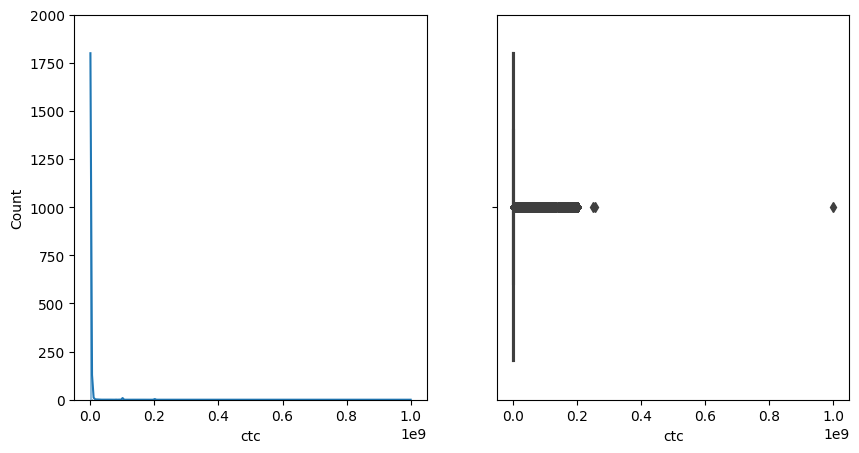

In [36]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.histplot(x=df["ctc"], kde=True)
plt.ylim(0,2000)

plt.subplot(1,2,2)
sns.boxplot(x=df["ctc"])
plt.show()

- `CTC` feature has extreme right skewness
- in `ctc` column it showing outliers

<Axes: xlabel='ctc'>

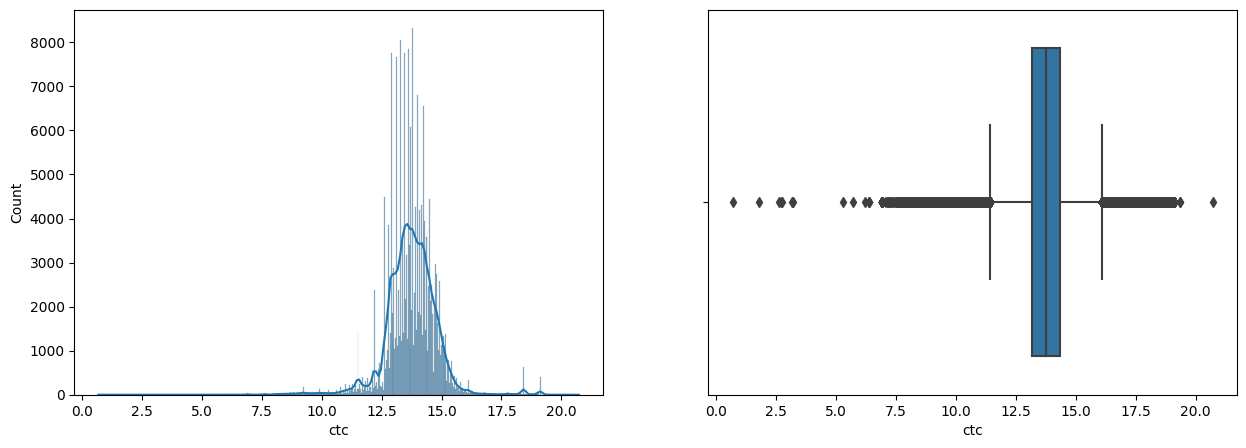

In [37]:
# using log transformation to check data distribution
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.histplot(x=np.log(df["ctc"]), kde=True)
plt.subplot(1,2,2)
sns.boxplot(x=np.log(df["ctc"]))

- Majority of the learners fall within the 12.5 -16 CTC range

#### distribution of `"ctc_updated_year"` feature, we can treat it as categorical feature

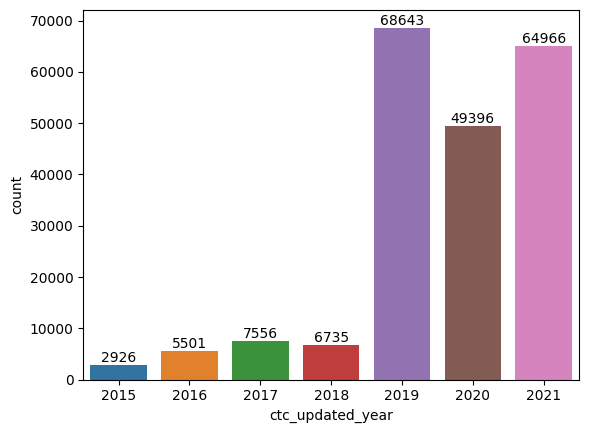

In [38]:
label= sns.countplot(x=df["ctc_updated_year"])
for i in label.containers:
  label.bar_label(i)
plt.show()

- in year 2019 most of the learner updated the CTC means got promotion followed by 2021 and 2020
- least promotion got in year 2015

### cleaning `"orgyear"` feature

In [39]:
# checking "orgyear" feature,previously we observed typographical errors or inaccuracies
lst[-10:-1]

[1976, 2027, 1981, 1973, 2106, 2107, 1972, 2101, 208]

- if the values are less than 10, it is possible user mentioning users experience]
- if values are greater than 2021 then it is imputed as 2021
- Remaining errors are tried were hardcoded

In [40]:
def orgyear_fix(x):
    if x["orgyear"]<=10:
        k = x["ctc_updated_year"]-x["orgyear"]
        return k
    elif x["orgyear"] > 2021:
        return 2021
    elif x["orgyear"]>=200 and x["orgyear"]<=202:
        return x["orgyear"]*10
    elif x["orgyear"]==206.0:
        return 2006
    elif x["orgyear"]==209.0:
        return 2009
    elif x["orgyear"]==208.0:
        return 2008
    elif x["orgyear"] == 91.0:
        return 1991
    elif x["orgyear"] == 83.0:
        return 1983
    elif x["orgyear"] == 38.0:
        return 2021
    elif x["orgyear"] == 1900.0:
        return x["ctc_updated_year"]
    else:
        return x["orgyear"]

In [41]:
df["orgyear"] = df.apply(orgyear_fix , axis = 1)

In [42]:
df["orgyear"].value_counts()

orgyear
2018    25255
2019    23426
2017    23236
2016    23044
2015    20610
2014    16695
2020    13426
2013    12353
2012    10493
2011     7970
2010     5752
2021     4928
2009     3778
2008     2729
2007     2257
2006     2076
2005     1873
2004     1455
2003     1018
2001      713
2002      685
2000      496
1999      340
1998      279
1997      234
1996      134
1995       94
1991       82
1993       74
1994       65
1992       47
1990       38
1989       22
1988       10
1986        8
1987        6
1985        5
1982        4
1984        3
1970        2
1972        1
1981        1
1973        1
1976        1
1971        1
1977        1
1983        1
1979        1
Name: count, dtype: int64

In [43]:
# in percentage
(df["orgyear"].value_counts(normalize=True)*100)[:10]

orgyear
2018    12.276216
2019    11.387157
2017    11.294799
2016    11.201470
2015    10.018326
2014     8.115281
2020     6.526251
2013     6.004676
2012     5.100548
2011     3.874141
Name: proportion, dtype: float64

- **56% Employment start date year is between 2015 to 2019** 

<Axes: xlabel='orgyear', ylabel='Count'>

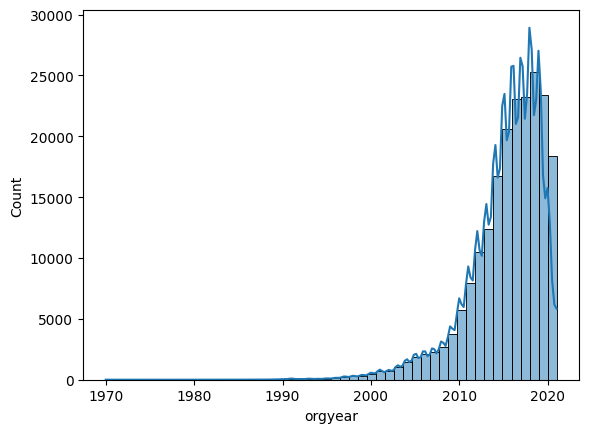

In [44]:
sns.histplot(df["orgyear"], bins= 50, kde= True)

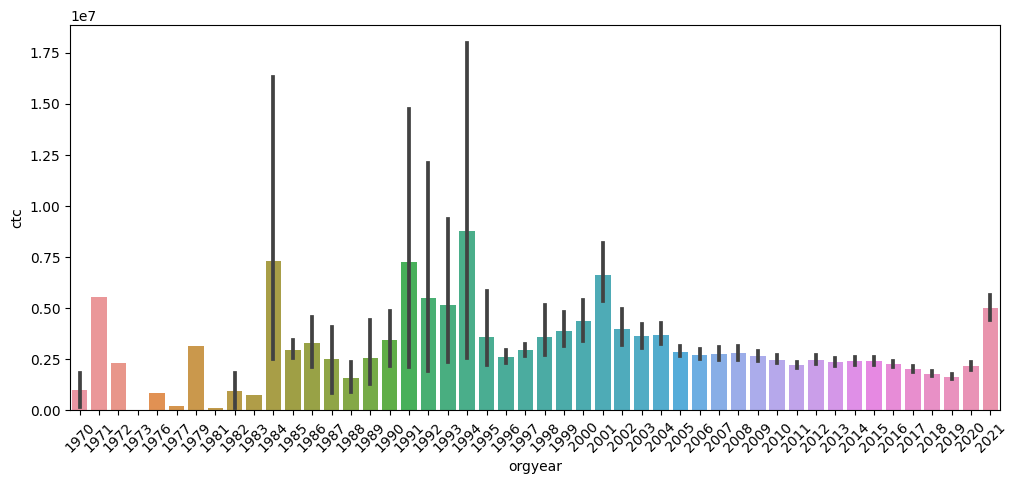

In [45]:
# mean CTC per year when joined the org
plt.figure(figsize=(12,5))
sns.barplot(data=df, x= "orgyear", y="ctc", estimator="mean")
plt.xticks(rotation= 45)
plt.show()

In [46]:
# removing the records where company or job_position reocords are not available
df= df.loc[~((df["company_hash"] == "") | (df["job_position"] == ""))]

In [47]:
df.shape

(205637, 6)

### Treating records having `'ctc_updated_year'` higher than their organization joining year `'orgyar'`

In [48]:
df.loc[df["ctc_updated_year"] < df["orgyear"]].head()

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year
8,utqoxontzn ojontbo,edabfebacbcbddacafbedefdbfcd,2020,450000,NaN,2019
17,puxn,bebacbdafcbcbceccfbbcdc,2020,1400000,NaN,2019
40,rvqotz nghmqg,bebbbadeedafdbdbed,2021,2500000,Other,2020
48,rgfto wgbuvzxto xzw,ceffcafbdfdeeaeeceeefdbc,2020,3010000,NaN,2019
56,axztqg xzzgcvnxgz ucn rna,aafddebdfcbabeccbce,2020,700000,Frontend Engineer,2019


In [49]:
#count of all above mentioned case
(df["ctc_updated_year"] < df["orgyear"]).sum()

8074

- We can see in above promotion year is mention before organisation joining year, which dosen't make any sense. 
- **To handle this we can replace max year between `"orgyear"` and `"ctc_updated_year"` and replace it with `"ctc_updated_year"`** 

In [50]:
df["ctc_updated_year"] = df[["ctc_updated_year","orgyear"]].max(axis = 1)

In [51]:
(df["ctc_updated_year"] < df["orgyear"]).sum()

0

### Feature Engineering `"year_of_exp"`

In [52]:
df["year_of_exp"]= 2024- df["orgyear"]

In [53]:
pd.DataFrame({"count":df["year_of_exp"].value_counts(), 
              "percent":df["year_of_exp"].value_counts(normalize=True)*100})

,count,percent
year_of_exp,,
6,25241,12.274542
5,23403,11.380734
7,23234,11.298550
8,23040,11.204209
9,20602,10.018625
10,16692,8.117216
4,13413,6.522659
11,12349,6.005242
12,10490,5.101222


- Most of the users have experiance between range of 6 to 10

In [54]:
df["year_of_exp"].describe()

count    205637.000000
mean          8.890997
std           4.223849
min           3.000000
25%           6.000000
50%           8.000000
75%          11.000000
max          54.000000
Name: year_of_exp, dtype: float64

- 75% of the users have experience less than or equal to 11 years 

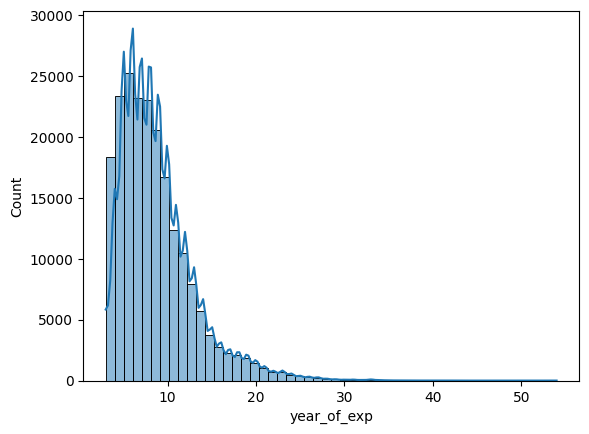

In [55]:
## distribution of "year_of_exp"
sns.histplot(df["year_of_exp"], kde=True, bins=50)
plt.show()

<Axes: >

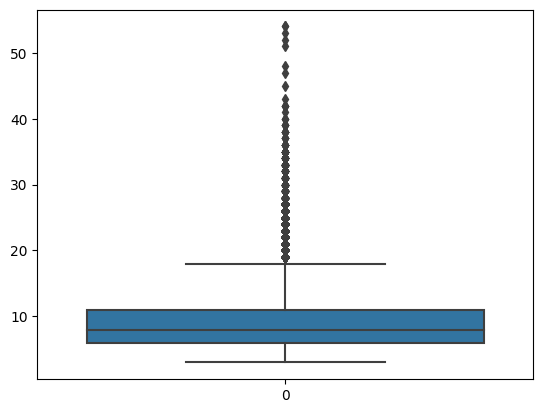

In [56]:
sns.boxplot(df["year_of_exp"])

(0.0, 400000000.0)

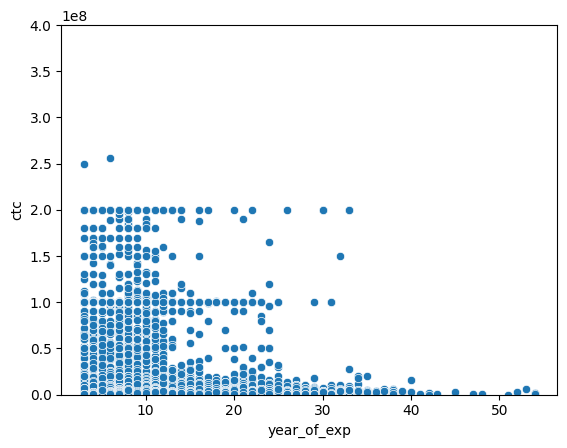

In [57]:
sns.scatterplot(data=df, y="ctc", x="year_of_exp")
plt.ylim(0, 0.4*(10**9))

In [237]:
df["year_of_exp"].quantile([0,0.02,0.5, 0.65, 0.80, 0.98, 0.99,1] )

0.00     4.0
0.02     4.0
0.50     8.0
0.65     9.0
0.80    12.0
0.98    19.0
0.99    20.0
1.00    22.0
Name: year_of_exp, dtype: float64

- **We can see most of the learner have experience between 8 to 12 years**

### Outliers treatment of `"year_of_exp"` feature

<Axes: >

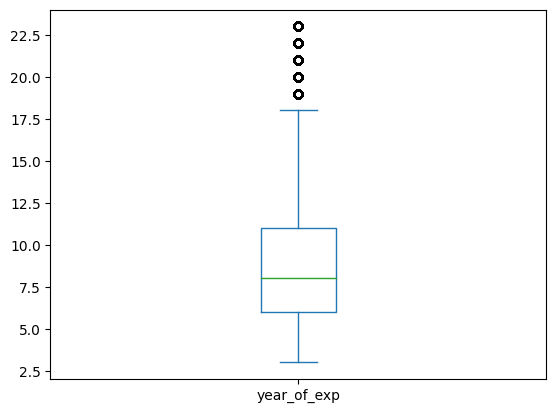

In [59]:
# treating outliers
df["year_of_exp"].clip(upper=df["year_of_exp"].quantile(0.99), lower=df["year_of_exp"].quantile(0)).plot(kind="box")

In [60]:
df = df.loc[((df["year_of_exp"]) > df["year_of_exp"].quantile(0.01)) & ((df["year_of_exp"]) < df["year_of_exp"].quantile(0.99))]

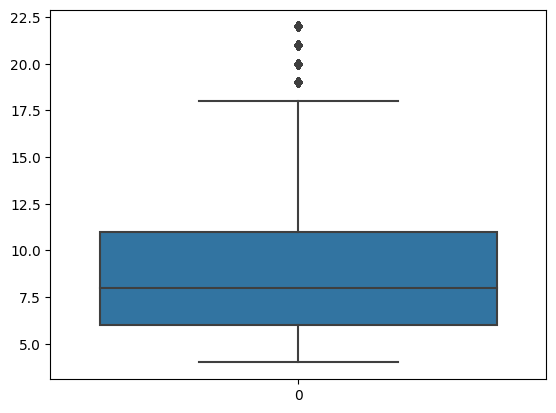

In [61]:
sns.boxplot(df["year_of_exp"])
plt.show()  

- While the boxplot indicates the presence of outliers, it's important to note that these outliers appear to follow a natural pattern.

### Outliers treatment of `"ctc"` feature

In [62]:
df["ctc"].quantile([0,0.2, 0.5, 0.75, 0.80,0.95, 0.985,0.99,1])

0.000    2.000000e+00
0.200    4.800000e+05
0.500    9.500000e+05
0.750    1.650000e+06
0.800    1.900000e+06
0.950    3.700000e+06
0.985    7.200000e+06
0.990    1.060000e+07
1.000    1.000150e+09
Name: ctc, dtype: float64

- As we can see 80% percent of learners ctc is less than or equal to 1900000

<Axes: >

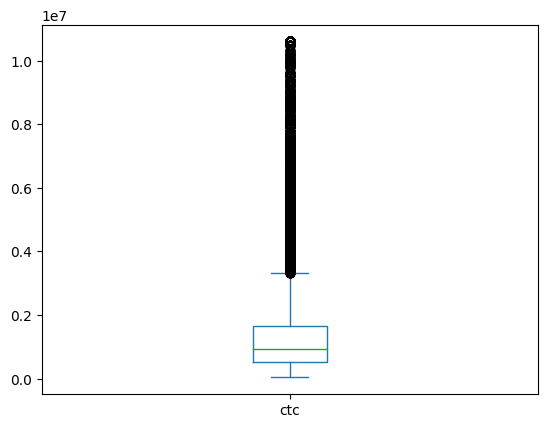

In [63]:
df["ctc"].clip(upper=df["ctc"].quantile(0.99), lower=df["ctc"].quantile(0.01)).plot(kind="box")

In [64]:
df = df.loc[((df.ctc) > df.ctc.quantile(0.01)) & ((df.ctc) < df.ctc.quantile(0.99))]

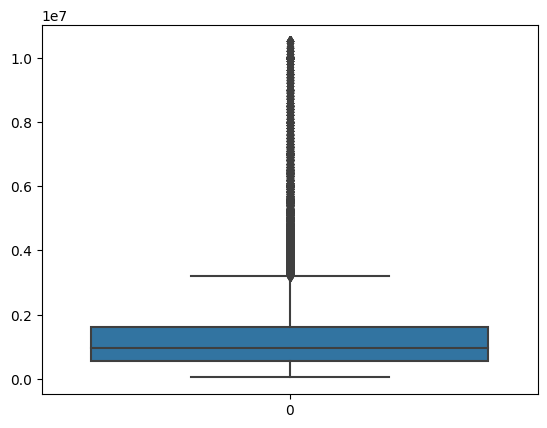

In [65]:
sns.boxplot(df["ctc"])
plt.show()       

- While the boxplot indicates the presence of outliers, it's important to note that these outliers appear to follow a natural pattern.

### Missing value treatment of `"job_position"` feature

In [66]:
# grouping data by company name and finding mode of each company job_position and filling null values with those mode
df['job_position'] = df.groupby('company_hash')['job_position'].transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else "other"))

In [67]:
df.isna().sum()

company_hash        0
email_hash          0
orgyear             0
ctc                 0
job_position        0
ctc_updated_year    0
year_of_exp         0
dtype: int64

In [68]:
df.head()

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,year_of_exp
0,atrgxnnt xzaxv,deadabcffcbcdcccaeacaf,2016,1100000,Other,2020,8
1,qtrxvzwt xzegwgbb rxbxnta,baafacbcbebacdaddcaabdccb,2018,449999,FullStack Engineer,2019,6
2,ojzwnvwnxw vx,cbcdfbcabaeaefddefdcdfbb,2015,2000000,Backend Engineer,2020,9
3,ngpgutaxv,effdedeaecafcaddbbcadddfec,2017,700000,Backend Engineer,2019,7
4,qxen sqghu,ffefcbacdbcbdfabbbadb,2017,1400000,FullStack Engineer,2019,7


In [69]:
df.shape

(194001, 7)

<Axes: >

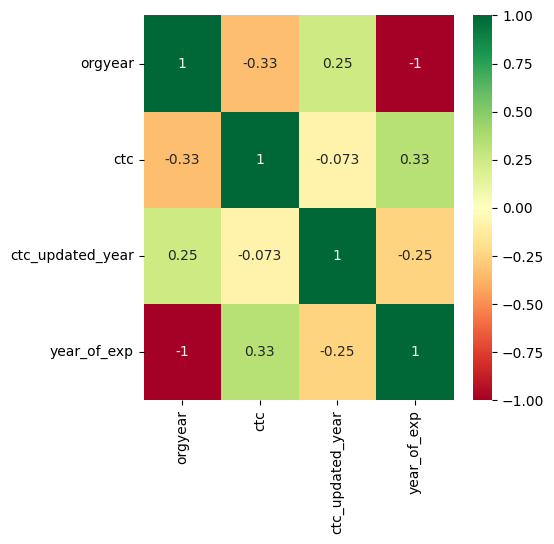

In [70]:
plt.figure(figsize=(5, 5))
sns.heatmap(df.corr(numeric_only=True) ,annot=True, cmap="RdYlGn")

- We can see `'year_of_exp'` and `"orgyear"` showing strong negative correlation of -1

- we can remove `"orgyear"` and only keep `"year_of_exp"`

- `"ctc"` and `"years_of_exp"` are showing waek positive correlation 

### Manual Clustering

- Manual Clustering on the basis of learner’s company, job position and years of experience.
- Getting the 5 point summary of CTC (mean, median, max, min, count etc) on the basis of Company, Job Position, Years of Experience.
- Merging the same with original dataset carefully and creating some flags showing learners with CTC greater than the Average of their Company’s department having same Years of Experience - Call that flag designation with values [1,2,3]
- Doing above analysis at Company & Job Position level. Name that flag Class with values [1,2,3]
- Repeating the same analysis at the Company level. Name that flag Tier with values [1,2,3]

#### Manual Clustering on the basis of learner’s company, job position and years of experience

In [71]:
agg_df= df.groupby(["company_hash", "job_position", "year_of_exp"]).agg({"ctc":["mean","median","max","min"]})
agg_df.head(5)

ctc  \
                                                                               mean   
company_hash                                 job_position     year_of_exp             
a                                            Product Manager  7            900000.0   
a b onttr wgqu                               Other            5            180000.0   
a j uvnxr owyggr ge tzsxzttqxzs vwvatbj vbmx Other            9            463999.0   
a ntwy ogrhnxgzo ucn rna                     Assistant        11           400000.0   
a ntwyzgrgsxto                               Android Engineer 10           710000.0   

                                                                                     \
                                                                             median   
company_hash                                 job_position     year_of_exp             
a                                            Product Manager  7            900000.0   
a b onttr wgqu                               Other            5            180000.0   
a j uvnxr owyggr ge tzsxzttqxzs vwvatbj vbmx Other            9            463999.0   
a ntwy ogrhnxgzo ucn rna                     Assistant        11           400000.0   
a ntwyzgrgsxto                               Android Engineer 10           710000.0   

                                                                                   \
                                                                              max   
company_hash                                 job_position     year_of_exp           
a                                            Product Manager  7            900000   
a b onttr wgqu                               Other            5            180000   
a j uvnxr owyggr ge tzsxzttqxzs vwvatbj vbmx Other            9            463999   
a ntwy ogrhnxgzo ucn rna                     Assistant        11           400000   
a ntwyzgrgsxto                               Android Engineer 10           710000   

                                                                                   
                                                                              min  
company_hash                                 job_position     year_of_exp          
a                                            Product Manager  7            900000  
a b onttr wgqu                               Other            5            180000  
a j uvnxr owyggr ge tzsxzttqxzs vwvatbj vbmx Other            9            463999  
a ntwy ogrhnxgzo ucn rna                     Assistant        11           400000  
a ntwyzgrgsxto                               Android Engineer 10           710000

In [72]:
agg_df = agg_df.reset_index()
agg_df.head(10)

company_hash      job_position year_of_exp  \
                                                                                
0                                             a   Product Manager           7   
1                                a b onttr wgqu             Other           5   
2  a j uvnxr owyggr ge tzsxzttqxzs vwvatbj vbmx             Other           9   
3                      a ntwy ogrhnxgzo ucn rna         Assistant          11   
4                                a ntwyzgrgsxto  Android Engineer          10   
5                                a ntwyzgrgsxto  Backend Engineer           8   
6                                a ntwyzgrgsxto  Backend Engineer           9   
7                                a ntwyzgrgsxto  Backend Engineer          10   
8                                a ntwyzgrgsxto  Backend Engineer          11   
9                                a ntwyzgrgsxto  Backend Engineer          18   

            ctc                               
           mean     median      max      min  
0  9.000000e+05   900000.0   900000   900000  
1  1.800000e+05   180000.0   180000   180000  
2  4.639990e+05   463999.0   463999   463999  
3  4.000000e+05   400000.0   400000   400000  
4  7.100000e+05   710000.0   710000   710000  
5  5.000000e+05   500000.0   500000   500000  
6  5.916667e+05   600000.0   600000   575000  
7  6.000000e+05   600000.0   600000   600000  
8  1.350000e+06  1350000.0  1350000  1350000  
9  4.000000e+06  4000000.0  4000000  4000000

In [73]:
agg_df.columns = [' '.join(col).strip() for col in agg_df.columns.values] 
agg_df.head(5)

,company_hash,job_position,year_of_exp,ctc mean,ctc median,ctc max,ctc min
0,a,Product Manager,7,900000.0,900000.0,900000,900000
1,a b onttr wgqu,Other,5,180000.0,180000.0,180000,180000
2,a j uvnxr owyggr ge tzsxzttqxzs vwvatbj vbmx,Other,9,463999.0,463999.0,463999,463999
3,a ntwy ogrhnxgzo ucn rna,Assistant,11,400000.0,400000.0,400000,400000
4,a ntwyzgrgsxto,Android Engineer,10,710000.0,710000.0,710000,710000


In [74]:
agg_df.shape

(93891, 7)

In [75]:
# merging agg_df with df
df_merged= df.merge(agg_df, on=("company_hash", "job_position", "year_of_exp"), how="left")
df_merged.head()

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,year_of_exp,ctc mean,ctc median,ctc max,ctc min
0,atrgxnnt xzaxv,deadabcffcbcdcccaeacaf,2016,1100000,Other,2020,8,1.100000e+06,1100000.0,1100000,1100000
1,qtrxvzwt xzegwgbb rxbxnta,baafacbcbebacdaddcaabdccb,2018,449999,FullStack Engineer,2019,6,7.742856e+05,750000.0,1200000,449999
2,ojzwnvwnxw vx,cbcdfbcabaeaefddefdcdfbb,2015,2000000,Backend Engineer,2020,9,2.000000e+06,2000000.0,2000000,2000000
3,ngpgutaxv,effdedeaecafcaddbbcadddfec,2017,700000,Backend Engineer,2019,7,1.436154e+06,1210000.0,3160000,700000
4,qxen sqghu,ffefcbacdbcbdfabbbadb,2017,1400000,FullStack Engineer,2019,7,1.400000e+06,1400000.0,1400000,1400000


In [76]:
df_compr=df_merged.copy()

In [77]:
# function to categorize the "ctc" 

def cat_ctc(row, comparison_column):
    if row["ctc"]<0.5 * row[comparison_column]:
        return 3
    elif row["ctc"]>1.5 * row[comparison_column]:
        return  1
    else:
        return 2

#### Flag calculation on the basis of company_has, job_position and year_of_exp

In [78]:
df_compr['ctc_flag_mean'] = df_compr.apply(cat_ctc, args=('ctc mean',), axis=1) 
df_compr['ctc_flag_median'] = df_compr.apply(cat_ctc, args=('ctc median',), axis=1) 
df_compr.head()

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,year_of_exp,ctc mean,ctc median,ctc max,ctc min,ctc_flag_mean,ctc_flag_median
0,atrgxnnt xzaxv,deadabcffcbcdcccaeacaf,2016,1100000,Other,2020,8,1.100000e+06,1100000.0,1100000,1100000,2,2
1,qtrxvzwt xzegwgbb rxbxnta,baafacbcbebacdaddcaabdccb,2018,449999,FullStack Engineer,2019,6,7.742856e+05,750000.0,1200000,449999,2,2
2,ojzwnvwnxw vx,cbcdfbcabaeaefddefdcdfbb,2015,2000000,Backend Engineer,2020,9,2.000000e+06,2000000.0,2000000,2000000,2,2
3,ngpgutaxv,effdedeaecafcaddbbcadddfec,2017,700000,Backend Engineer,2019,7,1.436154e+06,1210000.0,3160000,700000,3,2
4,qxen sqghu,ffefcbacdbcbdfabbbadb,2017,1400000,FullStack Engineer,2019,7,1.400000e+06,1400000.0,1400000,1400000,2,2


#### Manual Clustering on the basis of learner’s company and job position
     - Name that flag Class with values [1,2,3]

In [79]:
agg_df_company_job = df.groupby(['company_hash', 'job_position']).agg({ 'ctc':['mean','median','max','min'] }) 
agg_df_company_job = agg_df_company_job.reset_index() 
agg_df_company_job.columns = [' '.join(col).strip() for col in agg_df_company_job.columns.values] 
agg_df_company_job.head()

,company_hash,job_position,ctc mean,ctc median,ctc max,ctc min
0,a,Product Manager,900000.0,900000.0,900000,900000
1,a b onttr wgqu,Other,180000.0,180000.0,180000,180000
2,a j uvnxr owyggr ge tzsxzttqxzs vwvatbj vbmx,Other,463999.0,463999.0,463999,463999
3,a ntwy ogrhnxgzo ucn rna,Assistant,400000.0,400000.0,400000,400000
4,a ntwyzgrgsxto,Android Engineer,710000.0,710000.0,710000,710000


In [80]:
# mergining with df_compr

df_compr2 = df_compr.merge(agg_df_company_job, on=['company_hash','job_position'], how='left') 
df_compr2.head()

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,year_of_exp,ctc mean_x,ctc median_x,ctc max_x,ctc min_x,ctc_flag_mean,ctc_flag_median,ctc mean_y,ctc median_y,ctc max_y,ctc min_y
0,atrgxnnt xzaxv,deadabcffcbcdcccaeacaf,2016,1100000,Other,2020,8,1.100000e+06,1100000.0,1100000,1100000,2,2,1085000.0,1085000.0,1100000,1070000
1,qtrxvzwt xzegwgbb rxbxnta,baafacbcbebacdaddcaabdccb,2018,449999,FullStack Engineer,2019,6,7.742856e+05,750000.0,1200000,449999,2,2,972619.0,850000.0,2000000,300000
2,ojzwnvwnxw vx,cbcdfbcabaeaefddefdcdfbb,2015,2000000,Backend Engineer,2020,9,2.000000e+06,2000000.0,2000000,2000000,2,2,2000000.0,2000000.0,2000000,2000000
3,ngpgutaxv,effdedeaecafcaddbbcadddfec,2017,700000,Backend Engineer,2019,7,1.436154e+06,1210000.0,3160000,700000,3,2,1777750.0,1600000.0,4600000,520000
4,qxen sqghu,ffefcbacdbcbdfabbbadb,2017,1400000,FullStack Engineer,2019,7,1.400000e+06,1400000.0,1400000,1400000,2,2,810000.0,650000.0,1400000,540000


#### Flag class calculation

In [81]:
df_compr2['ctc_class_mean'] = df_compr2.apply(cat_ctc, args=('ctc mean_y',), axis=1) 
df_compr2['ctc_class_median'] = df_compr2.apply(cat_ctc, args=('ctc median_y',), axis=1) 
df_compr2.head()

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,year_of_exp,ctc mean_x,ctc median_x,ctc max_x,ctc min_x,ctc_flag_mean,ctc_flag_median,ctc mean_y,ctc median_y,ctc max_y,ctc min_y,ctc_class_mean,ctc_class_median
0,atrgxnnt xzaxv,deadabcffcbcdcccaeacaf,2016,1100000,Other,2020,8,1.100000e+06,1100000.0,1100000,1100000,2,2,1085000.0,1085000.0,1100000,1070000,2,2
1,qtrxvzwt xzegwgbb rxbxnta,baafacbcbebacdaddcaabdccb,2018,449999,FullStack Engineer,2019,6,7.742856e+05,750000.0,1200000,449999,2,2,972619.0,850000.0,2000000,300000,3,2
2,ojzwnvwnxw vx,cbcdfbcabaeaefddefdcdfbb,2015,2000000,Backend Engineer,2020,9,2.000000e+06,2000000.0,2000000,2000000,2,2,2000000.0,2000000.0,2000000,2000000,2,2
3,ngpgutaxv,effdedeaecafcaddbbcadddfec,2017,700000,Backend Engineer,2019,7,1.436154e+06,1210000.0,3160000,700000,3,2,1777750.0,1600000.0,4600000,520000,3,3
4,qxen sqghu,ffefcbacdbcbdfabbbadb,2017,1400000,FullStack Engineer,2019,7,1.400000e+06,1400000.0,1400000,1400000,2,2,810000.0,650000.0,1400000,540000,1,1


In [82]:
# aggregating based on company 
agg_df_company = df.groupby(['company_hash']).agg({ 'ctc':['mean','median','max','min'] }) 
agg_df_company = agg_df_company.reset_index() 
agg_df_company.columns = [' '.join(col).strip() for col in agg_df_company.columns.values] 
agg_df_company

,company_hash,ctc mean,ctc median,ctc max,ctc min
0,a,9.000000e+05,900000.0,900000,900000
1,a b onttr wgqu,1.800000e+05,180000.0,180000,180000
2,a j uvnxr owyggr ge tzsxzttqxzs vwvatbj vbmx,4.639990e+05,463999.0,463999,463999
3,a ntwy ogrhnxgzo ucn rna,4.000000e+05,400000.0,400000,400000
4,a ntwyzgrgsxto,1.361071e+06,610000.0,4000000,500000
...,...,...,...,...,...
34759,zyvzwt fgga qtztfvr eqvzwyxogq yi,9.000000e+05,900000.0,900000,900000
34760,zyvzwt wgzohrnxzs tzsxzttqo,9.400000e+05,940000.0,940000,940000
34761,zz,9.350000e+05,935000.0,1370000,500000
34762,zzb ztdnstz vacxogqj ucn rna,6.000000e+05,600000.0,600000,600000


In [83]:
# merge these values with df_comparison 
df_compr3 = df_compr2.merge(agg_df_company, on=['company_hash'], how='left') 
df_compr3.head()

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,year_of_exp,ctc mean_x,ctc median_x,ctc max_x,...,ctc mean_y,ctc median_y,ctc max_y,ctc min_y,ctc_class_mean,ctc_class_median,ctc mean,ctc median,ctc max,ctc min
0,atrgxnnt xzaxv,deadabcffcbcdcccaeacaf,2016,1100000,Other,2020,8,1.100000e+06,1100000.0,1100000,...,1085000.0,1085000.0,1100000,1070000,2,2,1.115667e+06,1070000.0,1771000,500000
1,qtrxvzwt xzegwgbb rxbxnta,baafacbcbebacdaddcaabdccb,2018,449999,FullStack Engineer,2019,6,7.742856e+05,750000.0,1200000,...,972619.0,850000.0,2000000,300000,3,2,1.180369e+06,900000.0,7000000,200000
2,ojzwnvwnxw vx,cbcdfbcabaeaefddefdcdfbb,2015,2000000,Backend Engineer,2020,9,2.000000e+06,2000000.0,2000000,...,2000000.0,2000000.0,2000000,2000000,2,2,2.000000e+06,2000000.0,2000000,2000000
3,ngpgutaxv,effdedeaecafcaddbbcadddfec,2017,700000,Backend Engineer,2019,7,1.436154e+06,1210000.0,3160000,...,1777750.0,1600000.0,4600000,520000,3,3,1.713929e+06,1400000.0,4700000,200000
4,qxen sqghu,ffefcbacdbcbdfabbbadb,2017,1400000,FullStack Engineer,2019,7,1.400000e+06,1400000.0,1400000,...,810000.0,650000.0,1400000,540000,1,1,9.400000e+05,850000.0,1400000,540000


#### Flag Tier calculation

In [84]:

df_compr3['ctc_tier_mean'] = df_compr3.apply(cat_ctc, args=('ctc mean',), axis=1) 
df_compr3['ctc_tier_median'] = df_compr3.apply(cat_ctc, args=('ctc median',), axis=1)
df_compr3.head()

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,year_of_exp,ctc mean_x,ctc median_x,ctc max_x,...,ctc max_y,ctc min_y,ctc_class_mean,ctc_class_median,ctc mean,ctc median,ctc max,ctc min,ctc_tier_mean,ctc_tier_median
0,atrgxnnt xzaxv,deadabcffcbcdcccaeacaf,2016,1100000,Other,2020,8,1.100000e+06,1100000.0,1100000,...,1100000,1070000,2,2,1.115667e+06,1070000.0,1771000,500000,2,2
1,qtrxvzwt xzegwgbb rxbxnta,baafacbcbebacdaddcaabdccb,2018,449999,FullStack Engineer,2019,6,7.742856e+05,750000.0,1200000,...,2000000,300000,3,2,1.180369e+06,900000.0,7000000,200000,3,3
2,ojzwnvwnxw vx,cbcdfbcabaeaefddefdcdfbb,2015,2000000,Backend Engineer,2020,9,2.000000e+06,2000000.0,2000000,...,2000000,2000000,2,2,2.000000e+06,2000000.0,2000000,2000000,2,2
3,ngpgutaxv,effdedeaecafcaddbbcadddfec,2017,700000,Backend Engineer,2019,7,1.436154e+06,1210000.0,3160000,...,4600000,520000,3,3,1.713929e+06,1400000.0,4700000,200000,3,2
4,qxen sqghu,ffefcbacdbcbdfabbbadb,2017,1400000,FullStack Engineer,2019,7,1.400000e+06,1400000.0,1400000,...,1400000,540000,1,1,9.400000e+05,850000.0,1400000,540000,2,1


### Based on the manual clustering done so far, answering few questions:

- **Top 10 employees (earning more than most of the employees in the company)**

In [85]:
df_compr3[["company_hash","email_hash", "ctc", "ctc_tier_mean"]].sort_values(by="ctc_tier_mean").head(10)

,company_hash,email_hash,ctc,ctc_tier_mean
145027,mqvchqv ogrhnxgzo,affccafbbdcdadcdbbabeafd,1710000,1
164301,zvz,acdcabedbdddfedcdcddcfe,7950000,1
74139,eqtoytq,eefdfacbecfafbaeabfede,3200000,1
29182,cvrhtrvmo,ccbfdfbeddbfdcbfacbe,1700000,1
119103,ovbohzs otbxwgzahwngq xzw,ccffccaafaceacfafbfabc,2800000,1
29175,xzegojo,abaeddadfaecfcfecaedcbdceadbcc,1050000,1
164312,uvjnb,bdeadbaacfacbcfcbbb,2600000,1
74149,bxwqgogen,dfbbafbeaeabbcacdefeb,4330000,1
119097,uvjuvr,adfdfcbbfbedcffbabdbda,4100000,1
164318,hmtq,dcdedfdfefbbadffbecbd,8000000,1


- **Top 10 employees of data science in Amazon / TCS etc earning more than their peers**

In [86]:
df_compr3.loc[df_compr3["job_position"]=="Data Scientist"][["company_hash","email_hash","job_position", "ctc_class_mean"]].sort_values(by="ctc_class_mean").head(10)

,company_hash,email_hash,job_position,ctc_class_mean
172420,lubgqsvz wyvot wg,dacfdcddeceafdbeeaccdc,Data Scientist,1
133702,ntwy bvyxzaqv,cffbfdbaddfdaabbdbc,Data Scientist,1
174518,bjznqv,eeafacbacaaeaacccabfc,Data Scientist,1
174502,lubgqsvz wyvot wg,cefeeedecfeefcbbccbedecbac,Data Scientist,1
95386,sgrabvz ovwyo,eedbbfacdecabecafccbca,Data Scientist,1
40009,nvnv wgzohrnvzwj otqcxwto ucn rna,ccebacbcaababecdffda,Data Scientist,1
134332,zvsvqqg,fabeaffddcaddbebafbbabdccdcafee,Data Scientist,1
134416,xmb fvnogz co fxuqg ygrbto,dadcebecdcbcbcbdcac,Data Scientist,1
40876,eqvwnvr vzvrjnxwo,faeffcdabdacafdaadcdceda,Data Scientist,1
173565,srgmvr bvznqv xzzgcvnxgzo,cefcdbdcbbcefffebcfedce,Data Scientist,1


- **Bottom 10 employees of data science in Amazon / TCS etc earning less than their peers**

In [87]:
df_compr3.loc[df_compr3["job_position"]=="Data Scientist"][["company_hash","email_hash","job_position", "ctc_class_mean"]].sort_values(by="ctc_class_mean", ascending= False).head(10)

,company_hash,email_hash,job_position,ctc_class_mean
193994,wyvqntq wgbbhzxwvnxgzo,ddddcafdacbdadddfdfcf,Data Scientist,3
27256,ytdvfvqt ntwyzgrgsxto,adceaaecdfffecebddefbbfce,Data Scientist,3
25169,wvuxrrvqj ntwyzgrgsxto,bdfafededfeddebabeaffcbfb,Data Scientist,3
181147,xb v onhatzn,adfaddabfadcaaebec,Data Scientist,3
163061,bxwqgogen,fbdffbcbbaffcffbaecbbcfecdd,Data Scientist,3
61601,uvjuvr,bfceaafeacffefbadfabdacd,Data Scientist,3
61301,uvjnb,beacfbeafddaafdcacbfabcd,Data Scientist,3
180786,atrgxnnt,ddecceebccbaceafcfffa,Data Scientist,3
26087,uqgavun ogrhnxgzo,cadecbefeddaffefdb,Data Scientist,3
26462,ytrrgoxcx ogenfvqt rvmo,ffbdcbaccfebbcdaffcacaadacdec,Data Scientist,3


- **Bottom 10 employees (earning less than most of the employees in the company)**

In [88]:
df_compr3[["company_hash","email_hash", "ctc", "ctc_tier_mean"]].sort_values(by="ctc_tier_mean", ascending= False).head(10)

,company_hash,email_hash,ctc,ctc_tier_mean
110977,rgfto wgbuvzxto xzw,becdfefedbcdcdbfbdadcbdaf,600000,3
43966,hsvb ogrhnxgzo ucn rna,fdedcbeadfaabecddffda,250000,3
172558,zgpxv,afecbceabbebdbbdcdbafeb,680000,3
43970,q ojontbo,bcaafebffdebbaebcffecfddbaedde,300000,3
81317,vbvkgz,ecafcaeefcbcafbfdbcfefddbe,370000,3
172565,zgmqgptqwgb,bfcfdaceeccffcfdacfaacaeead,600000,3
129987,ytdvfvqt ntwyzgrgsxto,fcfaedfbfdaefaabceccfcdfad,350000,3
43973,bowx xzw,fecdcabdfecccdfacdfeffffdeabfe,1000000,3
21714,arn rvmo,abbaaabfafdbeaefceddfeaaffecee,400000,3
172570,qtwpg,dcddbfbcfbeaaeeabefceaceca,1250000,3


- **Top 10 employees in company- X department - having 5/6/7 years of experience earning more than their peers**

In [89]:
df_compr3.loc[(df_compr3["year_of_exp"]>=5) & (df_compr3["year_of_exp"]<=7)][["email_hash","year_of_exp","job_position", "ctc_tier_mean"]].sort_values(by="ctc_tier_mean").head(10)

,email_hash,year_of_exp,job_position,ctc_tier_mean
193999,fbaaffcefdefeefcecfafa,5,Frontend Engineer,1
150002,becebdbdbadcadaedcbcacdfbd,7,Data Scientist,1
150058,cfceffbfdefccbbbedaeaafacd,6,Other,1
150107,ddeeccaabcdeefaaccedfffadbbeb,7,Android Engineer,1
150133,eeebeccefccbcffddbbcaffce,7,FullStack Engineer,1
150221,eadacdfbadbbfbdbd,5,Backend Engineer,1
150241,ebddeeeccafdaddbcafbdb,7,Backend Engineer,1
150311,dfddbdabdceeecaedefadb,5,Other,1
150326,ecedeaeddcabeeedbcbeececedfbc,6,FullStack Engineer,1
30512,cfcaddfffddacacd,7,Other,1


- **Top 10 companies (based on their CTC)**

In [90]:
df_compr3.sort_values(by="ctc", ascending=False)["company_hash"].head(10)

36596            bxwqgonqvntsj
72603                wgszxkvzn
49274         zgqnyqgu sqhbbvz
49068                   vbvkgz
102014           sgrabvz ovwyo
157188                  tbdwtr
174742                 sqghugz
12230     wgqztqongzt gzatbvza
1229                  atrr tbw
61511            bxwqgonqvntsj
Name: company_hash, dtype: object

- **Top 2 positions in every company (based on their CTC)**

In [91]:
top_2_positions = df_compr3.groupby('company_hash').apply(lambda x: x.nlargest(2, 'ctc')).reset_index(drop=True)

In [92]:
top_2_positions[["company_hash", "email_hash"]].head(10)

,company_hash,email_hash
0,a,aedcaafaffadcddbcada
1,a b onttr wgqu,bdfdcedddbcaeadedfddbedbacab
2,a j uvnxr owyggr ge tzsxzttqxzs vwvatbj vbmx,caaebdcbeddefbcfbebda
3,a ntwy ogrhnxgzo ucn rna,efbedacabdefadebffdef
4,a ntwy ogrhnxgzo ucn rna,efbedacabdefadebffdef
5,a ntwyzgrgsxto,acafdedcccddedaaadacb
6,a ntwyzgrgsxto,acafdedcccddedaaadacb
7,a rgsxw ucn rna,daebaffbdedabfcffeffcdf
8,a t oyvf ogenfvqt xzaxv ucn rna,decccffcbdcdeeeecfcbeaef
9,a t oyvf xzaxv ogenfvqt ucn rna,abcabebdfbeecbdcdafdefeed


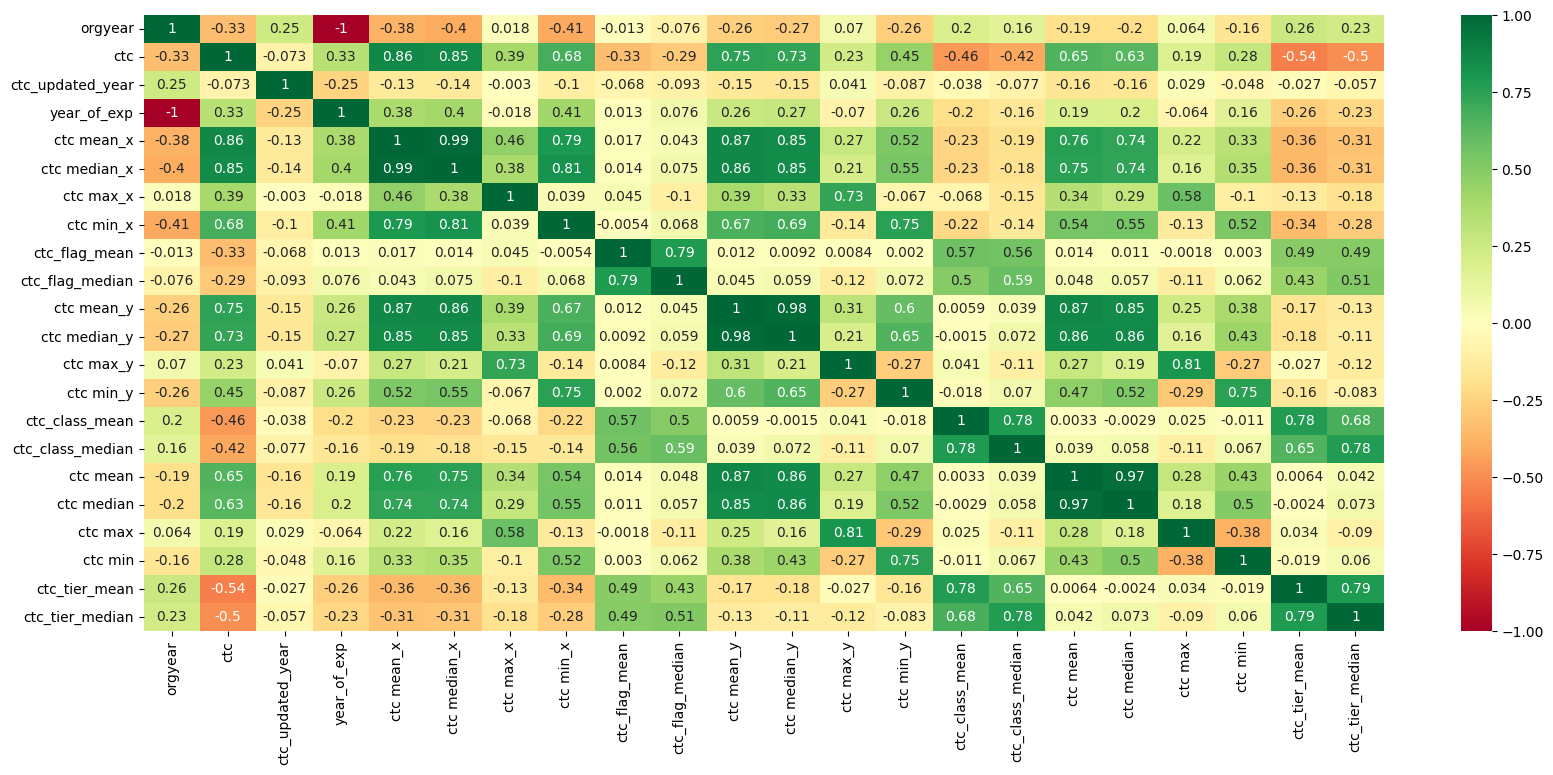

In [93]:
corrl = df_compr3.corr(numeric_only= True)


plt.figure(figsize=(20, 8))
sns.heatmap(corrl, annot=True, cmap="RdYlGn")
plt.show()

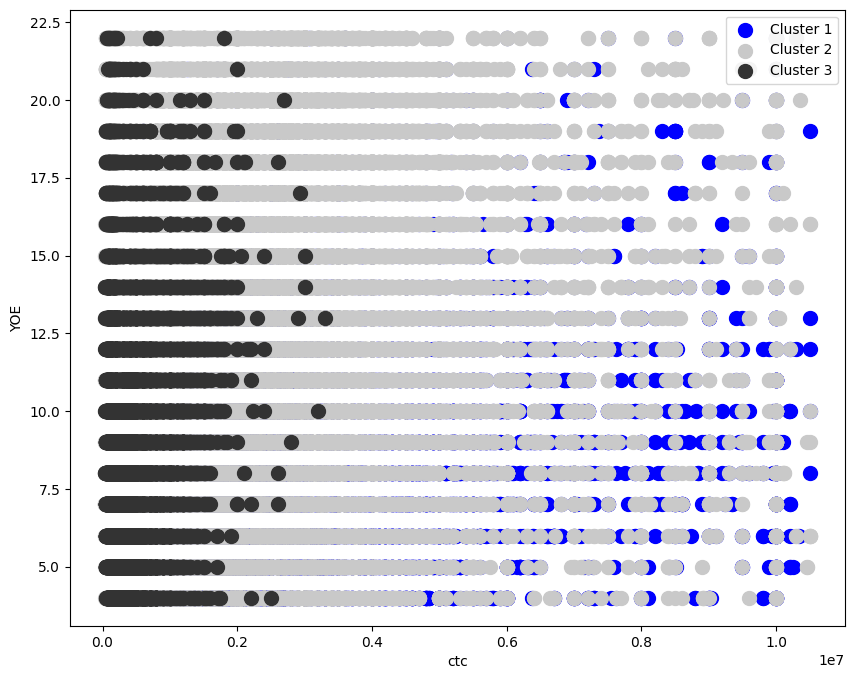

In [94]:
fig, ax = plt.subplots(figsize=(10,8)) 
plt.scatter(df_compr3[df_compr3['ctc_flag_mean'] == 1]['ctc'], df_compr3[df_compr3['ctc_flag_mean'] == 1]['year_of_exp'], s=100, c='blue', label = 'Cluster 1') 
plt.scatter(df_compr3[df_compr3['ctc_flag_mean'] == 2]['ctc'], df_compr3[df_compr3['ctc_flag_mean'] == 2]['year_of_exp'], s=100, c='0.788', label = 'Cluster 2') 
plt.scatter(df_compr3[df_compr3['ctc_flag_mean'] == 3]['ctc'], df_compr3[df_compr3['ctc_flag_mean'] == 3]['year_of_exp'], s=100, c='.2', label = 'Cluster 3') 
plt.xlabel('ctc') 
plt.ylabel('YOE') 
plt.legend() 
plt.show()

- **From above example it is clear that manual clustering is not clean and cluster are not seperated properly**

In [166]:
# 
df1= df_compr3.copy()
df1.head()

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,year_of_exp,ctc mean_x,ctc median_x,ctc max_x,...,ctc max_y,ctc min_y,ctc_class_mean,ctc_class_median,ctc mean,ctc median,ctc max,ctc min,ctc_tier_mean,ctc_tier_median
0,atrgxnnt xzaxv,deadabcffcbcdcccaeacaf,2016,1100000,Other,2020,8,1.100000e+06,1100000.0,1100000,...,1100000,1070000,2,2,1.115667e+06,1070000.0,1771000,500000,2,2
1,qtrxvzwt xzegwgbb rxbxnta,baafacbcbebacdaddcaabdccb,2018,449999,FullStack Engineer,2019,6,7.742856e+05,750000.0,1200000,...,2000000,300000,3,2,1.180369e+06,900000.0,7000000,200000,3,3
2,ojzwnvwnxw vx,cbcdfbcabaeaefddefdcdfbb,2015,2000000,Backend Engineer,2020,9,2.000000e+06,2000000.0,2000000,...,2000000,2000000,2,2,2.000000e+06,2000000.0,2000000,2000000,2,2
3,ngpgutaxv,effdedeaecafcaddbbcadddfec,2017,700000,Backend Engineer,2019,7,1.436154e+06,1210000.0,3160000,...,4600000,520000,3,3,1.713929e+06,1400000.0,4700000,200000,3,2
4,qxen sqghu,ffefcbacdbcbdfabbbadb,2017,1400000,FullStack Engineer,2019,7,1.400000e+06,1400000.0,1400000,...,1400000,540000,1,1,9.400000e+05,850000.0,1400000,540000,2,1


- **We can drop the `"orgyear"`  because its information is covered in `"year_of_exp"` feature**
- Also dropping the feature `"email_hash"`, like "ctc mean", "ctc median", max and min

In [167]:
df1.drop(columns = ["orgyear","email_hash","ctc mean", "ctc median", "ctc max", "ctc min", 'ctc mean_y', 'ctc median_y', 'ctc max_y', 'ctc min_y', 'ctc mean_x', 'ctc median_x',
       'ctc max_x', 'ctc min_x','ctc_flag_mean', 'ctc_flag_median', 'ctc_class_mean',
       'ctc_class_median', 'ctc_tier_mean', 'ctc_tier_median','ctc_updated_year'], axis=1, inplace=True)

### Data processing for Unsupervised clustering - encoding, Standardization of data

- If we use One hot encoding, that may not be the most practical approach due to the potential high dimensionality and sparsity it introduces.

- **Here we can use Frequency encoding**

In [168]:
# Create frequency maps
freq_map_company = df1['company_hash'].value_counts().to_dict()
freq_map_position = df1['job_position'].value_counts().to_dict()

# Map the frequency to the 'Company_hash' and 'job_position' feature
df1['company_hash'] = df1['company_hash'].map(freq_map_company)
df1['job_position'] = df1['job_position'].map(freq_map_position)

In [169]:
df1.head()

,company_hash,ctc,job_position,year_of_exp
0,9,1100000,23479,8
1,412,449999,27979,6
2,1,2000000,71006,9
3,70,700000,71006,7
4,6,1400000,27979,7


In [170]:
df1.columns

Index(['company_hash', 'ctc', 'job_position', 'year_of_exp'], dtype='object')

In [171]:
# naming the dataset as X
X= df1

#### Scaling of data

In [172]:
scaler= StandardScaler()

In [173]:
scaler.fit(X)
X=scaler.transform(X)

### K Means 

#### Checking clustering tendency

- **silhouette score** : finding silhouette score for different value of k. 

- **On whole dataset it is taking much time so taking random sample to find silhouette_scores**

In [174]:
# Specify the desired sample size
sample_size = 20000

# Randomly sample from the dataset
sampled_data = df1.sample(n=sample_size, random_state=42)

In [175]:
sampled_data.shape

(20000, 4)

In [176]:
sampled_data.head()

,company_hash,ctc,job_position,year_of_exp
153657,165,1200000,27979,5
98824,2400,2600000,71006,9
63583,2867,500000,378,12
9786,295,500000,71006,5
31295,734,1000000,71006,6


In [177]:
scaler= StandardScaler()

In [178]:
scaler.fit(sampled_data)

X_sample=scaler.transform(sampled_data)

In [179]:
kmeans_per_k = [KMeans(n_clusters=k,init="k-means++", n_init=10, random_state=42).fit(X_sample)
                for k in range(1, 10)]

In [180]:
silhouette_scores = [silhouette_score(X_sample, model.labels_)
                     for model in kmeans_per_k[1:]]

In [181]:
silhouette_scores

[0.31780758070677095,
 0.3624677880103344,
 0.3864523747484329,
 0.384484981001998,
 0.3655519750617476,
 0.3173751779656056,
 0.3249104386114646,
 0.3291005134879898]

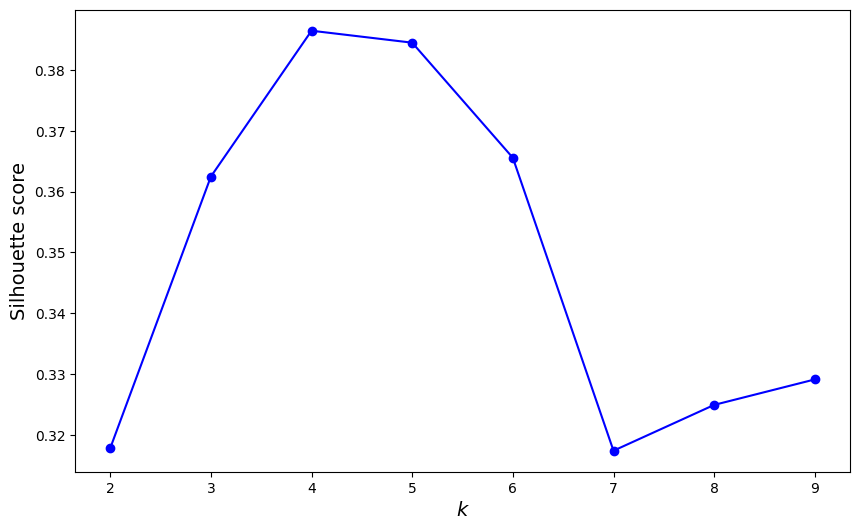

In [182]:
plt.figure(figsize=(10, 6))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.show()

- From above plot we can see at 4 silhouette_score is highest 
- We can pick 4 or 5 as we can see there is no much difference between their silhouette_scores

#### Now lets first check Elbow method on sample dataset and then with whole dataset

In [183]:
# with sample dataset
kmeans_per_k = [KMeans(n_clusters=k,init="k-means++", n_init=15, random_state=42).fit(X_sample)
                for k in range(1, 10)]

inertias = [model.inertia_ for model in kmeans_per_k]

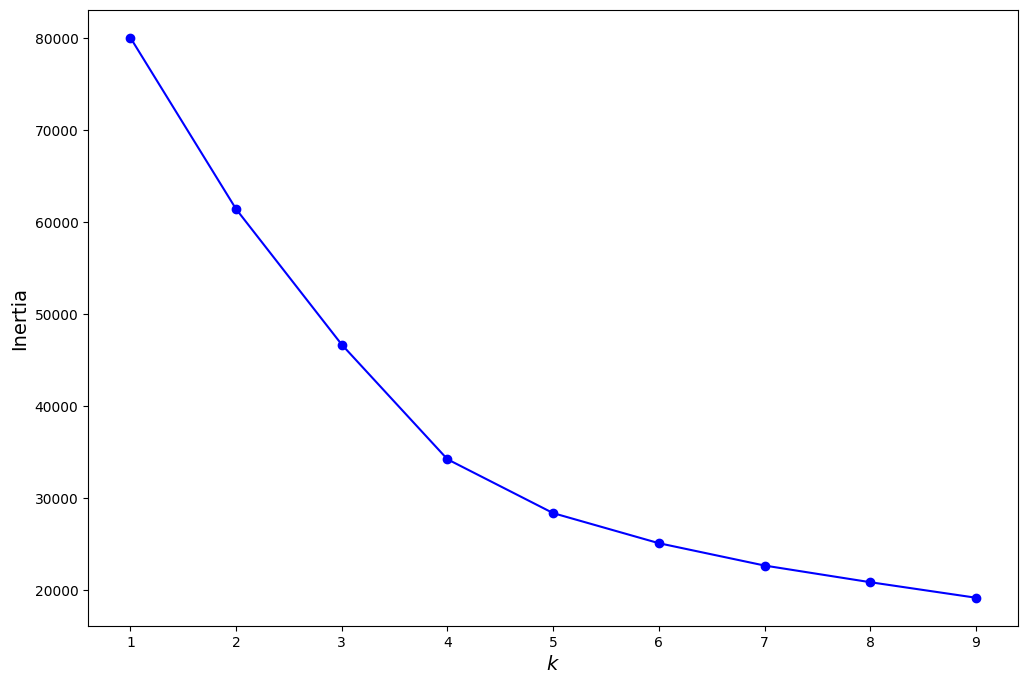

In [184]:
plt.figure(figsize=(12, 8))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.show()

In [185]:
# with whole data set
kmeans_per_k = [KMeans(n_clusters=k,init="k-means++", n_init=15, random_state=42).fit(X)
                for k in range(1, 10)]

inertias = [model.inertia_ for model in kmeans_per_k]

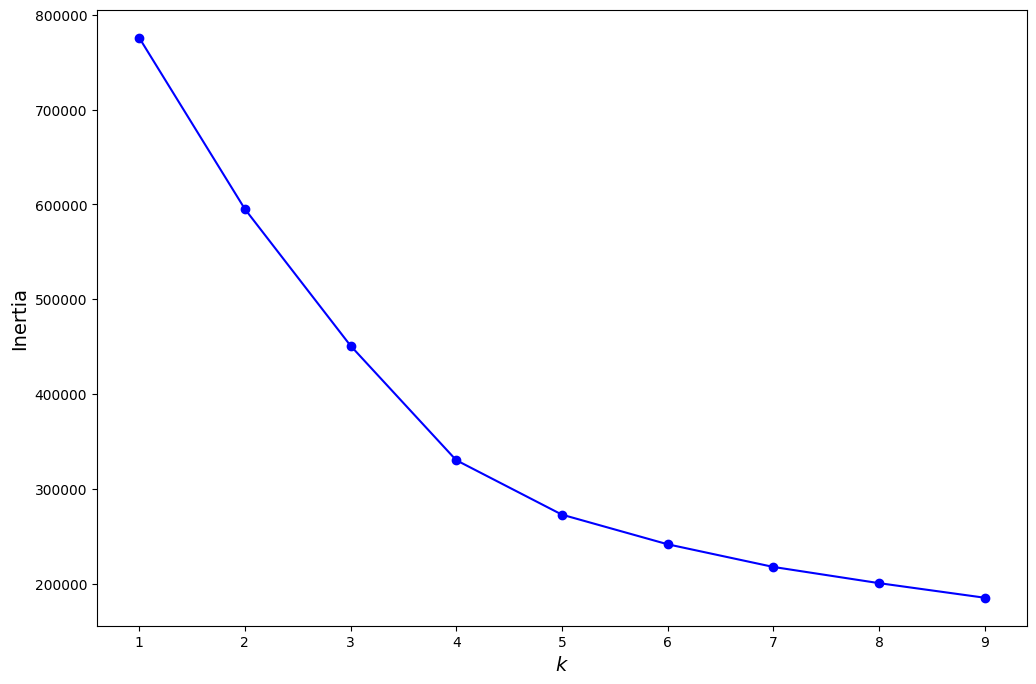

In [186]:
plt.figure(figsize=(12, 8))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)

plt.show()

- From the above elbow plot we can see near point 4 where drop sharply and then slow down.
- **from both the plot we can choose k= 4 as we also seen in silhouette_score 4 is highest**

In [187]:
scaled_df= pd.DataFrame(X, columns=df1.columns, index=df.index)

In [188]:
scaled_df.head(2)

,company_hash,ctc,job_position,year_of_exp
0,-0.493042,-0.163827,-0.396374,-0.217443
1,-0.275159,-0.721849,-0.239654,-0.761059


In [189]:
# training model using 3 clusters

k = 4
model = KMeans(n_clusters=k, init = 'k-means++', n_init=10,random_state=42)

In [190]:
y_md = model.fit_predict(scaled_df)
viz_df = scaled_df
viz_df['y_md'] = y_md

In [191]:
viz_df['y_md'].value_counts()

y_md
1    92803
2    59064
3    29068
0    13066
Name: count, dtype: int64

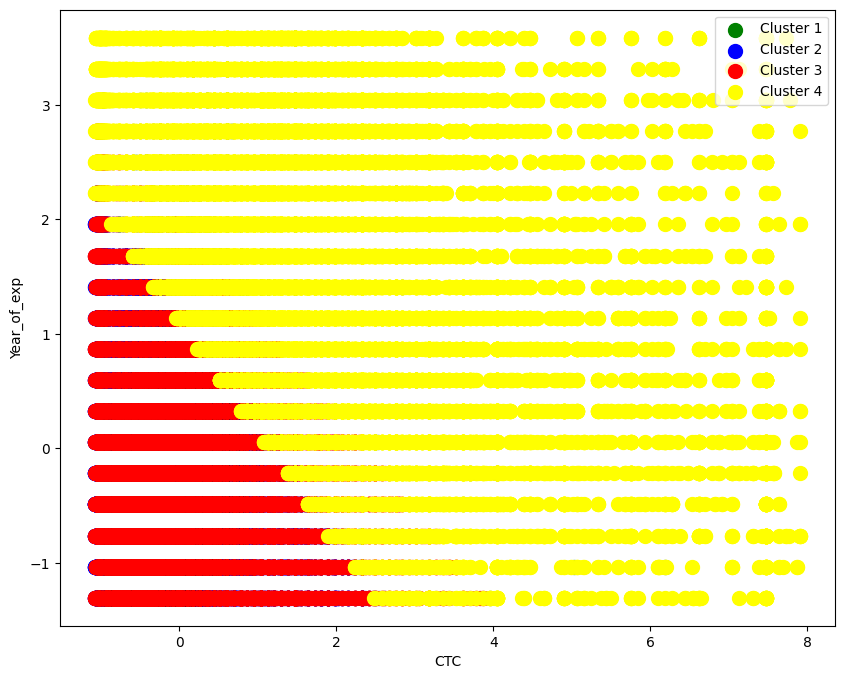

In [192]:
fig, ax = plt.subplots(figsize=(10,8))
plt.scatter(viz_df[viz_df['y_md'] == 0]['ctc'], viz_df[viz_df['y_md'] == 0]['year_of_exp'], s=100, c='Green', label='Cluster 1')
plt.scatter(viz_df[viz_df['y_md'] == 1]['ctc'], viz_df[viz_df['y_md'] == 1]['year_of_exp'], s=100, c='Blue', label='Cluster 2')
plt.scatter(viz_df[viz_df['y_md'] == 2]['ctc'], viz_df[viz_df['y_md'] == 2]['year_of_exp'], s=100, c='Red', label='Cluster 3')
plt.scatter(viz_df[viz_df['y_md'] == 3]['ctc'], viz_df[viz_df['y_md'] == 3]['year_of_exp'], s=100, c='Yellow', label='Cluster 4')
plt.xlabel('CTC')
plt.ylabel('Year_of_exp')
plt.legend()
plt.show()

- Only using the 2 feature clusters are overlapping to each other

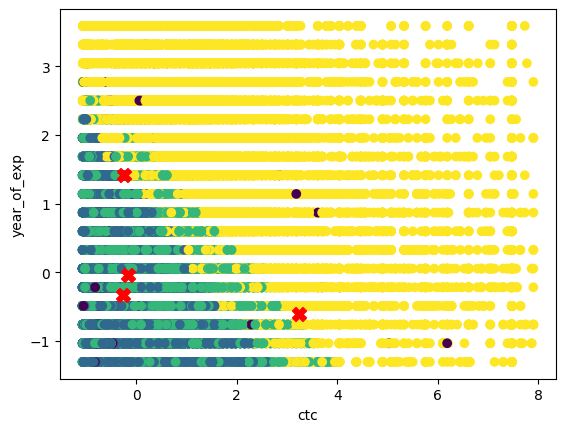

In [193]:
def viz_clusters(kmeans):
    plt.scatter(viz_df['ctc'], viz_df['year_of_exp'], c=viz_df['y_md'])
    plt.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:, 1],
                color="red",
                marker="X",
                s=100)
    plt.xlabel('ctc')
    plt.ylabel('year_of_exp')

viz_clusters(model)

- There is some distinction between clusters, but making sense out of this is a bit hard from this plot.
- A better alternative would be a line polar plot from plotly library - useful for visualizing multi-dimensional data

In [194]:
import plotly.express as px

In [195]:
polar = viz_df.groupby("y_md").mean().reset_index()
polar = pd.melt(polar, id_vars=["y_md"])
polar

,y_md,variable,value
0,0,company_hash,3.229205
1,1,company_hash,-0.269073
2,2,company_hash,-0.170248
3,3,company_hash,-0.246542
4,0,ctc,-0.600871
5,1,ctc,-0.334115
6,2,ctc,-0.041196
7,3,ctc,1.420499
8,0,job_position,0.110390
9,1,job_position,-0.715479


In [196]:
"""
  'polar' : customer dataset we are using
  'r' :  mean values for each feature which will be connected using lines
  'theta' : variables where each of the feature will have an angle and
            color will be based on the label of the clusters.
"""
fig = px.line_polar(polar, r="value", theta="variable", color="y_md", line_close=True,height=700,width=800)
fig.show()

- from above plot we can there are 4 type of users with different level of values in the feature
- `label 0` learners have very few years of experience so their ctc also low

- `label 1` learners have slightly more experience and ctc than user from label 0 but there company_hash feature has lower frequency

- `label 2` learners have good ctc and experience compare to `label 0 and 1` and they also have good job positions frequency
- `label 3` learners have very high ctc and level of experience compare to other label learners.

### Hierarchical Clustering

- **Taking the random sample from scaled dataset for better and efficient  results.**

In [207]:
# Specify the desired sample size
sample_size = 1000

# Randomly sample from the dataset
sampled_scaled_df = scaled_df.sample(n=sample_size, random_state=42)

In [208]:
sampled_scaled_df.shape

(1000, 5)

In [209]:
# dropping the previously labeled column "y_md"

sampled_scaled_df.drop(columns="y_md", inplace=True, axis=1)

In [210]:
sampled_scaled_df.shape

(1000, 4)

In [211]:
sampled_scaled_df.head()

,company_hash,ctc,job_position,year_of_exp
163051,-0.408700,-0.077977,-0.239654,-1.032866
104893,0.799663,1.123916,1.258830,0.054364
67629,1.052148,-0.678924,-1.200903,0.869787
10486,-0.338415,-0.678924,1.258830,-1.032866
33398,-0.101068,-0.249676,1.258830,-0.761059


In [212]:
# hierarchical clustering to plot the Dendogram
Z = sch.linkage(sampled_scaled_df, method='ward')

In [213]:
Z.shape

(999, 4)

Text(0, 0.5, 'distance')

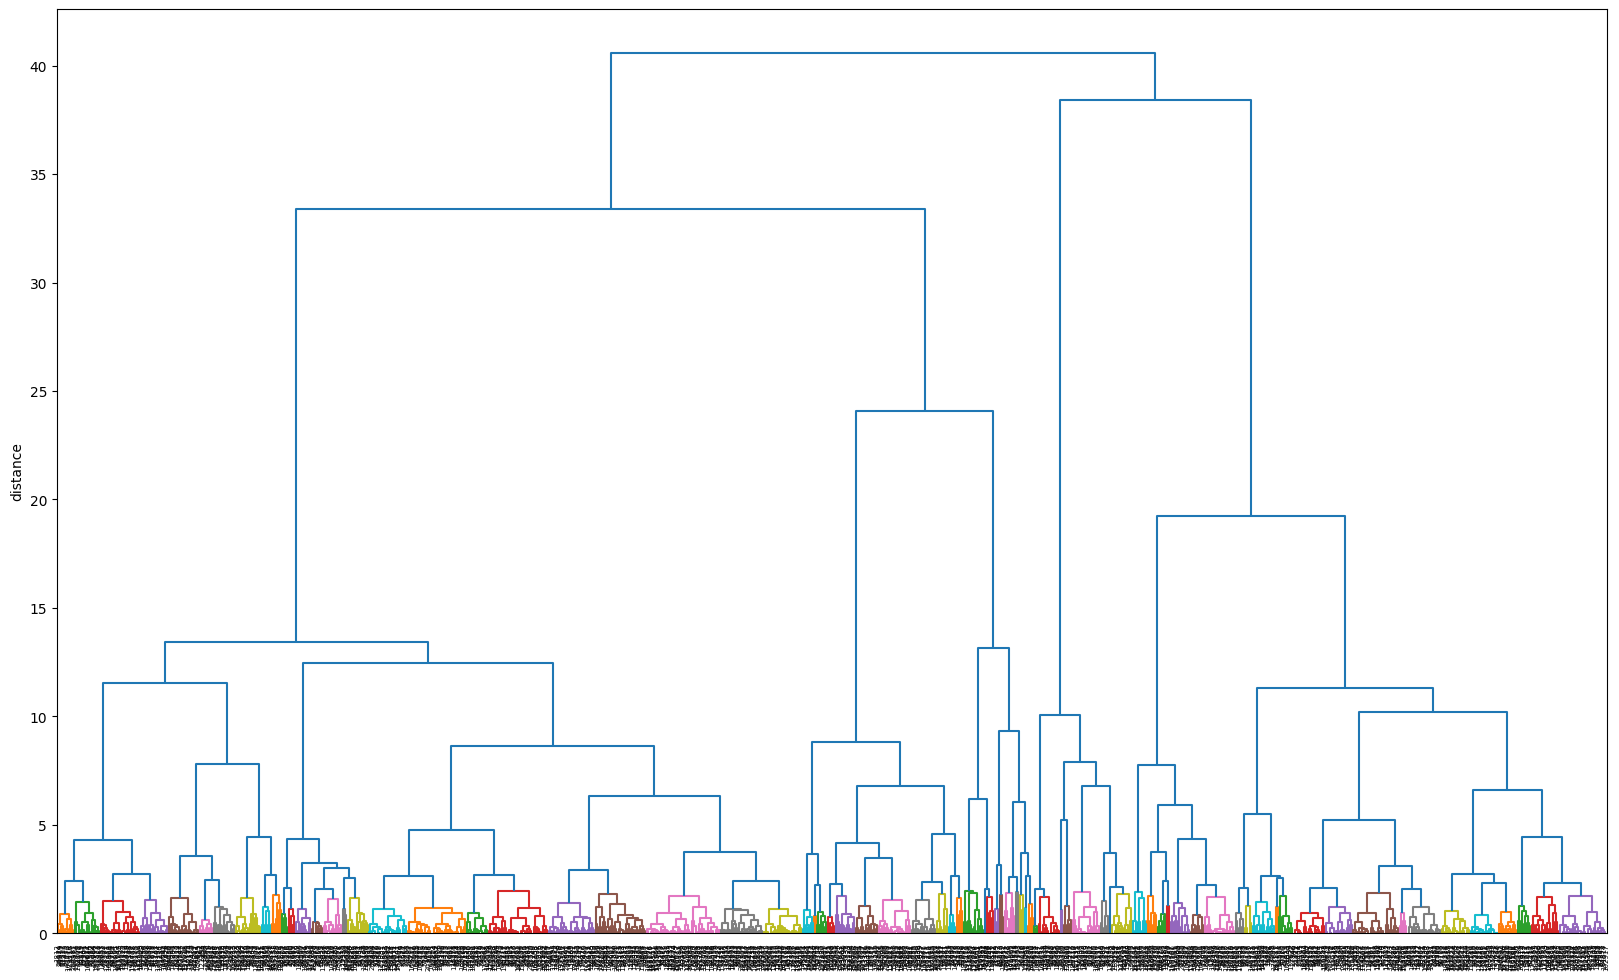

In [214]:
# plotting dendogram
fig, ax = plt.subplots(figsize=(20, 12))
sch.dendrogram(Z, labels=sampled_scaled_df.index, ax=ax, color_threshold=2)
plt.xticks(rotation=90)
ax.set_ylabel('distance')

#### Calculating the number of clusters

Text(0, 0.5, 'distance')

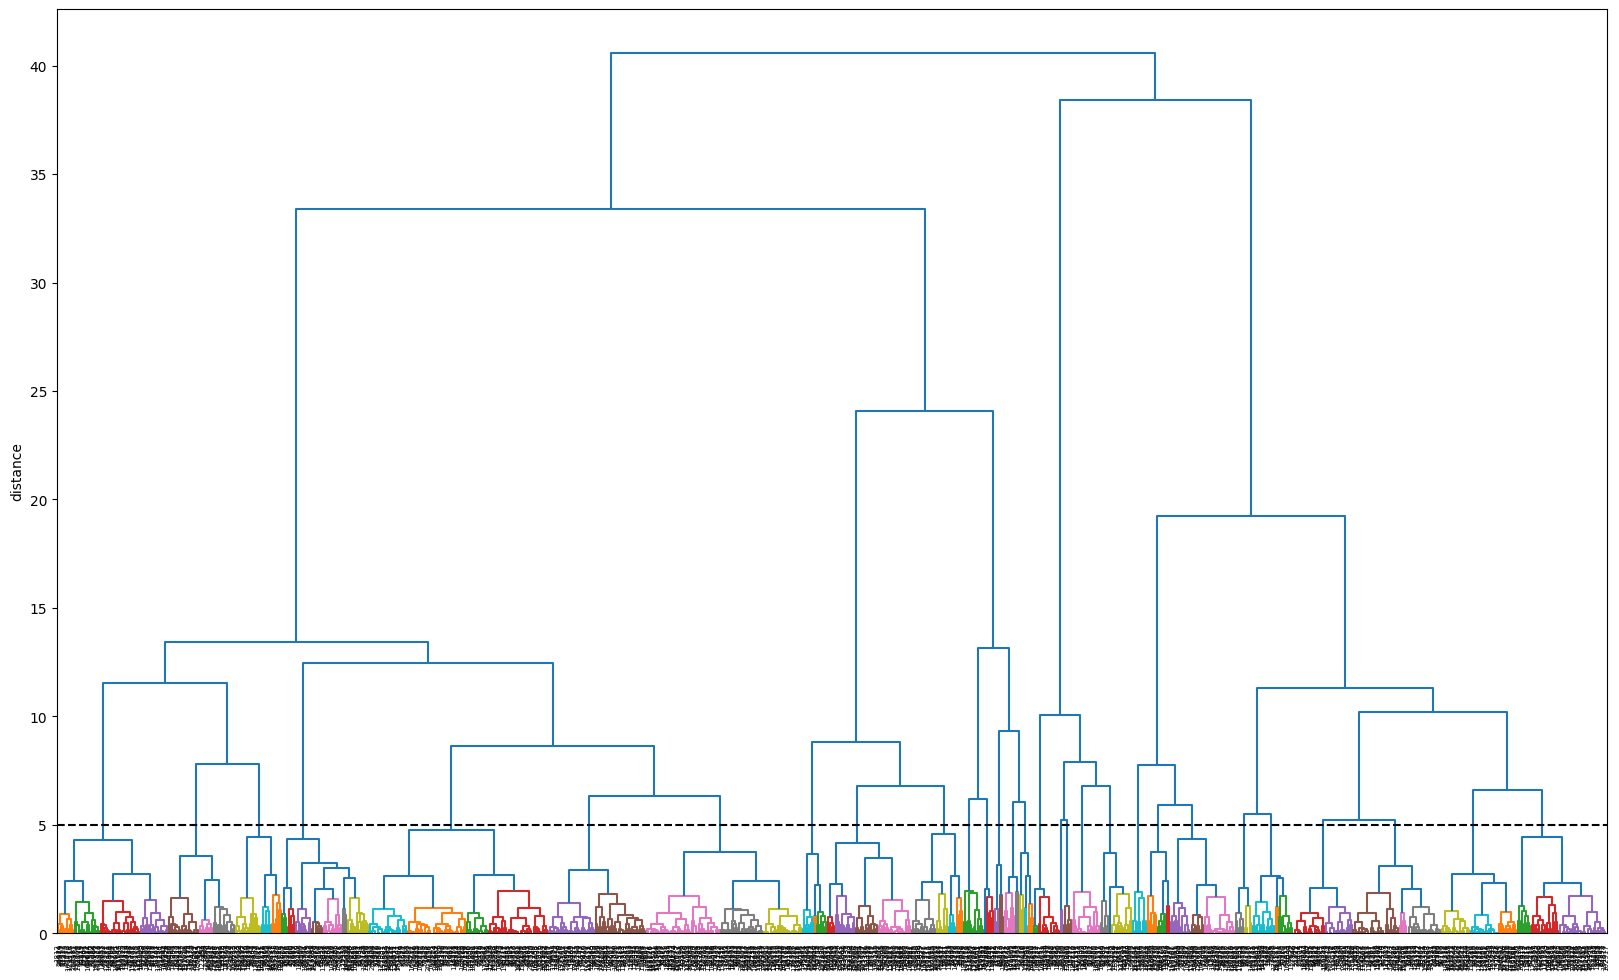

In [217]:
fig, ax = plt.subplots(figsize=(20, 12))
sch.dendrogram(Z, labels=sampled_scaled_df.index, ax=ax, color_threshold=2)
plt.xticks(rotation=90)
plt.axhline(y=5, color='k', linestyle='--')
ax.set_ylabel('distance')

#### Performing Agglomerative Clustering with 4 clusters

In [220]:
# create Agglomerative clusters
model_2 = AgglomerativeClustering(n_clusters=4, affinity = 'euclidean', linkage = 'ward')
y_pred = model_2.fit_predict(sampled_scaled_df)

In [223]:
y_pred[:20]

array([3, 1, 3, 1, 1, 1, 3, 3, 1, 1, 1, 2, 3, 1, 1, 0, 1, 0, 3, 3],
      dtype=int64)

In [225]:
agl_df = sampled_scaled_df
agl_df['label'] = y_pred

In [227]:
agl_df.head()

,company_hash,ctc,job_position,year_of_exp,label
163051,-0.408700,-0.077977,-0.239654,-1.032866,3
104893,0.799663,1.123916,1.258830,0.054364,1
67629,1.052148,-0.678924,-1.200903,0.869787,3
10486,-0.338415,-0.678924,1.258830,-1.032866,1
33398,-0.101068,-0.249676,1.258830,-0.761059,1


#### Plotting the characteristics of the learned clusters

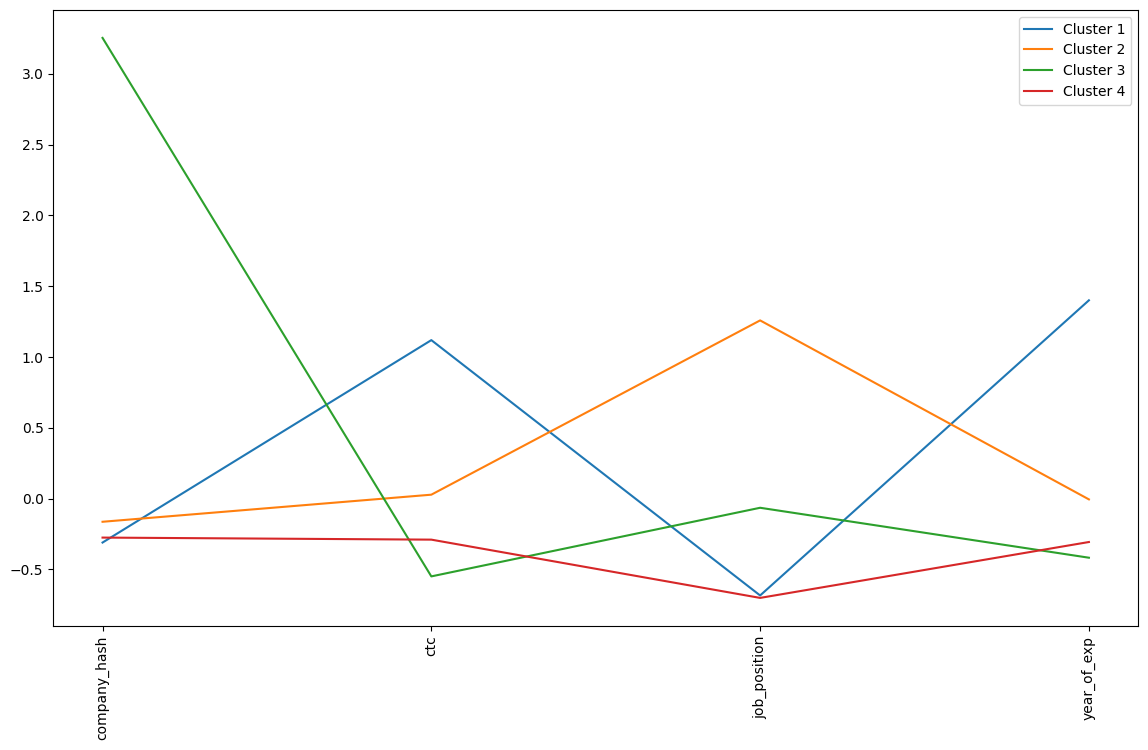

In [229]:
#Plot a line graph to see the characteristics of the clusters

clustered_df = agl_df.groupby('label').mean()

labels = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4']

plt.figure(figsize=(14,8))
plt.plot(clustered_df.T, label=labels)
plt.xticks(rotation=90)
plt.legend(labels)


# Insights & Recommendations

1. During manual clustering, we couldn't find clear differences in clusters created using the average or middle value of CTC. To improve this, we made Designation Flag, Class Flag, and Tier Flag. We attempted to group Years of Experience (YOE) with CTC for these clusters. The CTC flag values (1 for top and 3 for bottom) can help categorize and find employees based on their job position, company hash, and YOE.

2. For people with 8-12 years of experience, the CTC varies widely, with most of it concentrated in the 8 years of work experience. According to the data, CTC depends on factors other than YOE. There is also more data available for the 8-12 YOE range.

3. The CTC updated year and YOE show a negative correlation. It makes sense that CTC updates decrease as YOE increases, especially for promotions to Manager/Sr Manager roles, which take more years. Most people received CTC increments between 2019 and 2021, suggesting a strong job market during these years.

4. The dataset mostly includes data from people with 3-12 years of experience. While we can try to collect data for other experience years, the density of data is inconsistent. Although we can use SMOTE to address this, we prefer to keep the original data for unsupervised learning.

5. When using KMeans clustering, we found that the ideal number of clusters is 4 based on the Elbow method and silhouette_scores. 

6. Based on the clusters and overall data, we recommend the company to hire employees based on skills rather than Years of Experience (YOE). Across all clusters, the trend shows that CTC varies widely across a broad range of YOE, indicating that good companies tend to offer competitive CTC regardless of the job position.